In [154]:
#Start by importing the following libraries
#data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', size=24)
plt.rc('axes', titlesize=24)

#linear-tree objects
from lineartree import LinearTreeRegressor
from sklearn.linear_model import LinearRegression

#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt import OmltBlock
from omlt.lineartree import LinearTreeGDPFormulation, LinearTreeModel
import omlt

import numpy as np
import pyomo.environ as pe

from omlt.formulation import _PyomoFormulation, _setup_scaled_inputs_outputs
from pyomo.gdp import Disjunct, Disjunction
import pprint
pp = pprint.PrettyPrinter(indent=4)


In [90]:
df = pd.read_csv("./data/sin_quadratic.csv",index_col=[0])

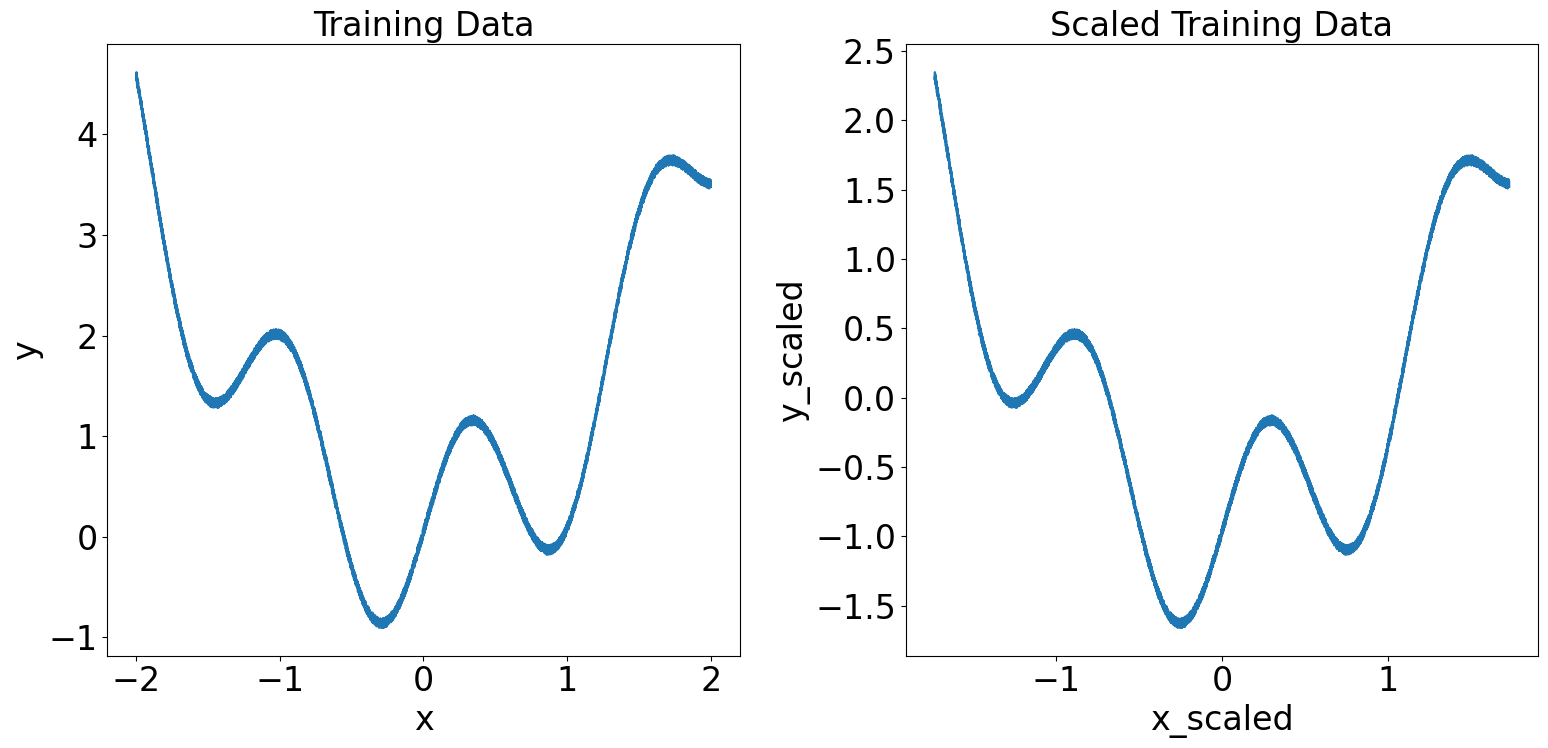

In [91]:
#retrieve input 'x' and output 'y' from the dataframe
x = df["x"]
y = df["y"]

#calculate mean and standard deviation, add scaled 'x' and scaled 'y' to the dataframe
mean_data = df.mean(axis=0)
std_data = df.std(axis=0)
df["x_scaled"] = (df['x'] - mean_data['x']) / std_data['x']
df["y_scaled"] = (df['y'] - mean_data['y']) / std_data['y']

#create plots for unscaled and scaled data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.plot(x, y)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Training Data")

ax2.plot(df["x_scaled"], df["y_scaled"])
ax2.set_xlabel("x_scaled")
ax2.set_ylabel("y_scaled")
ax2.set_title("Scaled Training Data")

plt.tight_layout()


In [92]:
#Build the linear-tree model
regr = LinearTreeRegressor(LinearRegression(),
                           criterion='mse',
                           max_bins=120,
                           min_samples_leaf=30,
                           max_depth=8)


In [93]:
#Data needs to be in array and reshaped
x_scaled = df["x_scaled"].to_numpy().reshape(-1,1)
y_scaled = df["y_scaled"].to_numpy().reshape(-1,1)

#train the linear tree on the scaled data
history1 = regr.fit(x_scaled,y_scaled)

In [94]:
#note: we calculate the unscaled output for each neural network to check the predictions
y_predict_scaled_lt = regr.predict(x_scaled)
y_predict_lt = y_predict_scaled_lt * (std_data['y']) + mean_data['y']


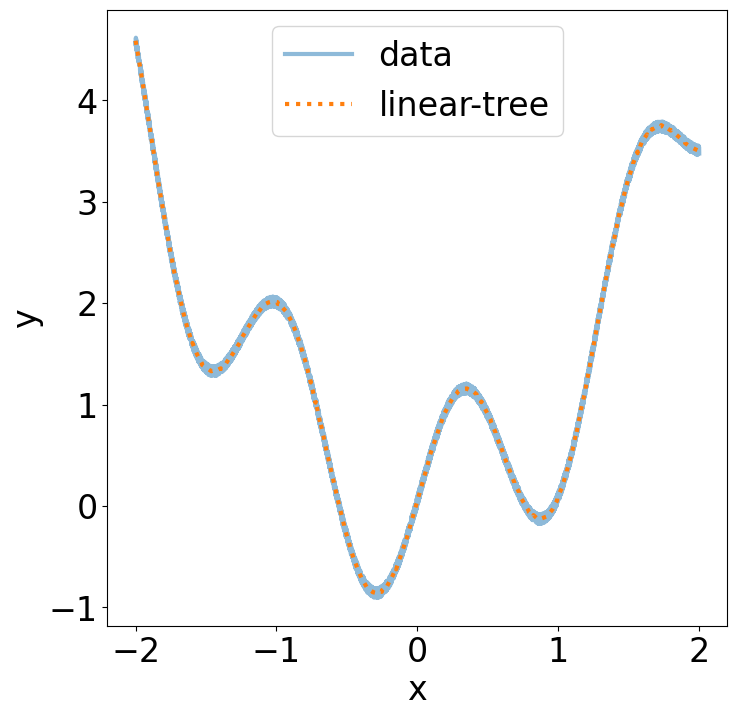

In [95]:
#create a single plot with the original data and each neural network's predictions
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.plot(x, y, linewidth=3.0, label="data", alpha=0.5)
ax.plot(x, y_predict_lt, linewidth=3.0,
        linestyle="dotted", label="linear-tree")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()


In [96]:
#create an omlt scaling object
scaler = omlt.scaling.OffsetScaling(offset_inputs=[mean_data['x']],
                    factor_inputs=[std_data['x']],
                    offset_outputs=[mean_data['y']],
                    factor_outputs=[std_data['y']])

#create the input bounds. note that the key `0` corresponds to input `0` and that we also scale the input bounds
input_bounds={0:((min(df['x']) - mean_data['x'])/std_data['x'],
                 (max(df['x']) - mean_data['x'])/std_data['x'])};
print(scaler)
print("Scaled input bounds: ",input_bounds)

Scaled input bounds:  {0: (-1.731791015101997, 1.731791015101997)}


In [97]:
model = regr

In [98]:
leaves = model.summary(only_leaves=True)
splits = model.summary()

for leaf in leaves:
    # print(leaf)
    del splits[leaf]
    leaves[leaf]['slope'] = list(leaves[leaf]['models'].coef_)
    leaves[leaf]['intercept'] = leaves[leaf]['models'].intercept_

# leaves

In [99]:
for split in splits:
    left_child = splits[split]['children'][0]
    right_child = splits[split]['children'][1]

    if left_child in splits:
        splits[left_child]['parent'] = split
    else:
        leaves[left_child]['parent'] = split
    
    if right_child in splits:
        splits[right_child]['parent'] = split
    else:
        leaves[right_child]['parent'] = split

In [100]:
def find_all_children_splits(split, splits_dict):
    """
    This helper function finds all multigeneration children splits for an 
    argument split.

    Arguments:
        split --The split for which you are trying to find children splits
        splits_dict -- A dictionary of all the splits in the tree

    Returns:
        A list containing the Node IDs of all children splits
    """
    all_splits = []

    # Check if the immediate left child of the argument split is also a split.
    # If so append to the list then use recursion to generate the remainder
    left_child = splits_dict[split]['children'][0]
    if left_child in splits_dict:
        all_splits.append(left_child)
        all_splits.extend(find_all_children_splits(left_child, splits_dict))

    # Same as above but with right child
    right_child = splits_dict[split]['children'][1]
    if right_child in splits_dict:
        all_splits.append(right_child)
        all_splits.extend(find_all_children_splits(right_child, splits_dict))

    return all_splits


In [101]:
def find_all_children_leaves(split, splits_dict, leaves_dict):
    """
    This helper function finds all multigeneration children leaves for an 
    argument split.

    Arguments:
        split -- The split for which you are trying to find children leaves
        splits_dict -- A dictionary of all the split info in the tree
        leaves_dict -- A dictionary of all the leaf info in the tree

    Returns:
        A list containing all the Node IDs of all children leaves
    """
    all_leaves = []

    # Find all the splits that are children of the relevant split
    all_splits = find_all_children_splits(split, splits_dict)

    # Ensure the current split is included
    if split not in all_splits:
        all_splits.append(split)

    # For each leaf, check if the parents appear in the list of children
    # splits (all_splits). If so, it must be a leaf of the argument split
    for leaf in leaves_dict:
        if leaves_dict[leaf]['parent'] in all_splits:
            all_leaves.append(leaf)

    return all_leaves

In [102]:
for split in splits:
    # print("split:" + str(split))
    left_child = splits[split]['children'][0]
    right_child = splits[split]['children'][1]
    
    if left_child in splits:
        # means left_child is split
        splits[split]['left_leaves'] = find_all_children_leaves(
            left_child, splits, leaves
            )
    else:
        # means left_child is leaf
        splits[split]['left_leaves'] = [left_child]
        # print("left_child" + str(left_child))
    
    if right_child in splits:
        splits[split]['right_leaves'] = find_all_children_leaves(
            right_child, splits, leaves
            )
    else:
        splits[split]['right_leaves'] = [right_child]
        # print("right_child" + str(right_child))

In [106]:
# splits

In [116]:
splitting_thresholds = {}
for split in splits:
    var = splits[split]['col']
    splitting_thresholds[var] = {}
for split in splits:
    var = splits[split]['col']
    splitting_thresholds[var][split] = splits[split]['th']

In [122]:
# splitting_thresholds

In [121]:
for var in splitting_thresholds:
    splitting_thresholds[var] = dict(
        sorted(splitting_thresholds[var].items(), key=lambda x: x[1])
        )
# splitting_thresholds

In [128]:
splitting_thresholds[0]

{9: -1.70269,
 12: -1.67358,
 7: -1.58626,
 10: -1.55716,
 16: -1.52805,
 5: -1.49895,
 19: -1.46984,
 8: -1.44073,
 20: -1.41163,
 3: -1.38252,
 27: -1.35342,
 25: -1.32431,
 6: -1.2661,
 31: -1.23699,
 26: -1.20789,
 32: -1.17878,
 36: -1.14968,
 1: -1.12057,
 43: -1.09146,
 41: -0.97504,
 44: -0.94594,
 39: -0.91683,
 51: -0.88772,
 49: -0.85862,
 42: -0.82951,
 4: -0.80041,
 57: -0.7713,
 55: -0.7422,
 58: -0.71309,
 40: -0.68398,
 65: -0.65488,
 63: -0.62577,
 66: -0.59667,
 56: -0.56756,
 64: -0.50935,
 72: -0.48024,
 74: -0.45114,
 0: -0.42203,
 85: -0.39293,
 83: -0.36382,
 86: -0.33472,
 81: -0.30561,
 84: -0.2765,
 92: -0.2474,
 79: -0.21829,
 97: -0.18919,
 100: -0.16008,
 95: -0.13098,
 103: -0.07276,
 98: 0.07276,
 104: 0.16008,
 82: 0.18919,
 109: 0.21829,
 112: 0.2474,
 96: 0.2765,
 110: 0.30561,
 77: 0.33472,
 117: 0.36382,
 120: 0.39293,
 80: 0.42203,
 118: 0.45114,
 124: 0.48024,
 126: 0.50935,
 128: 0.53846,
 2: 0.56756,
 137: 0.59667,
 135: 0.62577,
 138: 0.68398,
 

In [129]:
for split in splits:
    var = splits[split]['col']
    splits[split]['y_index'] = []
    splits[split]['y_index'].append(var)
    splits[split]['y_index'].append(
        list(splitting_thresholds[var]).index(split)
    )
    # print(list(splitting_thresholds[var]).index(split))


In [130]:
# splits

In [131]:
L = np.array(list(leaves.keys()))
features = np.arange(0,len(leaves[L[0]]['slope']))

In [136]:
for leaf in leaves:
    leaves[leaf]['bounds'] = {}
for th in features:
    for leaf in leaves:
        leaves[leaf]['bounds'][th] = [None, None]

In [138]:
for split in splits:
    var = splits[split]['col']
    for leaf in splits[split]['left_leaves']:
        leaves[leaf]['bounds'][var][1] = splits[split]['th']

    for leaf in splits[split]['right_leaves']:
        leaves[leaf]['bounds'][var][0] = splits[split]['th']

In [142]:
leaves

{11: {'loss': 0.0004,
  'samples': 85,
  'models': LinearRegression(),
  'slope': [-6.666268],
  'intercept': -9.219344,
  'parent': 9,
  'bounds': {0: [None, -1.70269]}},
 13: {'loss': 0.00046,
  'samples': 84,
  'models': LinearRegression(),
  'slope': [-7.3968883],
  'intercept': -10.465888,
  'parent': 12,
  'bounds': {0: [-1.70269, -1.67358]}},
 14: {'loss': 0.00044,
  'samples': 252,
  'models': LinearRegression(),
  'slope': [-7.324207],
  'intercept': -10.345491,
  'parent': 12,
  'bounds': {0: [-1.67358, -1.58626]}},
 15: {'loss': 0.00045,
  'samples': 84,
  'models': LinearRegression(),
  'slope': [-6.8426375],
  'intercept': -9.580907,
  'parent': 10,
  'bounds': {0: [-1.58626, -1.55716]}},
 17: {'loss': 0.00038,
  'samples': 84,
  'models': LinearRegression(),
  'slope': [-6.6189394],
  'intercept': -9.23088,
  'parent': 16,
  'bounds': {0: [-1.55716, -1.52805]}},
 18: {'loss': 0.00048,
  'samples': 84,
  'models': LinearRegression(),
  'slope': [-5.983848],
  'intercept': 

In [141]:
# regr.summary()

In [118]:
# splitting_thresholds

In [144]:
#create a LinearTreeModel Object
ltmodel = LinearTreeModel(regr,scaler,input_bounds)

In [149]:
#create an omlt scaling object
scaler = omlt.scaling.OffsetScaling(offset_inputs=[mean_data['x']],
                    factor_inputs=[std_data['x']],
                    offset_outputs=[mean_data['y']],
                    factor_outputs=[std_data['y']])

#create the input bounds. note that the key `0` corresponds to input `0` and that we also scale the input bounds
input_bounds={0:((min(df['x']) - mean_data['x'])/std_data['x'],
                 (max(df['x']) - mean_data['x'])/std_data['x'])};
print(scaler)
print("Scaled input bounds: ",input_bounds)

Scaled input bounds:  {0: (-1.731791015101997, 1.731791015101997)}


In [145]:
model_definition = ltmodel
leaves = model_definition._leaves
input_bounds = model_definition._scaled_input_bounds

In [147]:
L = np.array(list(leaves.keys()))
features = np.arange(0, len(leaves[L[0]]['slope']))

In [148]:
def reassign_none_bounds(leaves, input_bounds):
    """
    This helper function reassigns bounds that are None to the bounds
    input by the user

    Arguments:
        leaves -- The dictionary of leaf information. Attribute of the 
            LinearTreeModel object
        input_bounds -- The nested dictionary

    Returns:
        The modified leaves dict without any bounds that are listed as None
    """
    L = np.array(list(leaves.keys()))
    features = np.arange(0, len(leaves[L[0]]['slope']))

    for l in L:
        for f in features:
            if leaves[l]['bounds'][f][0] == None:
                leaves[l]['bounds'][f][0] = input_bounds[f][0]
            if leaves[l]['bounds'][f][1] == None:
                leaves[l]['bounds'][f][1] = input_bounds[f][1]

    return leaves


In [150]:
leaves = reassign_none_bounds(leaves, input_bounds)

In [152]:
def build_output_bounds(leaves, input_bounds):
    """
    This function develops bounds of the output variable based on the values
    of the input_bounds and the signs of the slope

    Arguments:
        leaves -- Dict of leaf information
        input_bounds -- Dict of input bounds

    Returns:
        List that contains the conservative lower and upper bounds of the 
        output variable
    """
    L = np.array(list(leaves.keys()))
    features = np.arange(0, len(leaves[L[0]]['slope']))

    # Initialize bounds and variables
    bounds = [0, 0]
    upper_bound = 0
    lower_bound = 0
    for l in leaves:
        slopes = leaves[l]['slope']
        intercept = leaves[l]['intercept']
        for k in features:
            if slopes[k] <= 0:
                upper_bound += slopes[k] * input_bounds[k][0] + intercept
                lower_bound += slopes[k] * input_bounds[k][1] + intercept
            else:
                upper_bound += slopes[k] * input_bounds[k][1] + intercept
                lower_bound += slopes[k] * input_bounds[k][0] + intercept
            if upper_bound >= bounds[1]:
                bounds[1] = upper_bound
            if lower_bound <= bounds[0]:
                bounds[0] = lower_bound
        upper_bound = 0
        lower_bound = 0

    return bounds


In [153]:
output_bounds = build_output_bounds(leaves, input_bounds)
output_bounds

[-23.275752644957162, 7.148448622340542]